# **Importacion paquetes**
---

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import shap

/Users/mariolamas/anaconda3/envs/socialnetwork/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Carga de datos**
---

In [13]:
aparts=pd.read_csv('../seleccion_vars/aparts/DatasetAirbnb_Varselect_v1.csv')
coments=pd.read_csv('../seleccion_vars/coments/DatasetAirbnb_Review_Varselect_v1.csv')

data=pd.merge(aparts,coments,left_on='URL',right_on='apart_id')
print('Tamaño: ',data.shape)
print('Columnas: ',data.columns)

Tamaño:  (17711, 33)
Columnas:  Index(['ID', 'Titulo', 'Descripcion Simple', 'Evaluaciones', 'Tipo', 'Precio',
       'URL', 'Capacidad', 'Baños', 'Baño Compartido', 'Latitud', 'Longitud',
       'Pais', 'Precio_por_persona', 'Rating', 'imagen', 'user_id', 'apart_id',
       'ubicacion', 'gender', 'rating', 'sentimiento', 'prom_long_word',
       'num_adj', 'text_clean', 'tokens', 'prob_ruido', 'prob_limp',
       'prob_ubi', 'prob_wf', 'prob_park', 'prob_bañ', 'num_toks'],
      dtype='object')


In [14]:
var_eliminar=['Titulo','Descripcion Simple','URL','imagen','user_id','apart_id','text_clean','tokens']
data.drop(var_eliminar,axis=1,inplace=True)

# **Modelo de Catboost**
---

In [15]:
X=data.drop('rating',axis=1)
y=data['rating']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=.2)

In [16]:
catb_reg=CatBoostRegressor(silent=True)
catb_reg.fit(X_train,y_train)

# **Evaluacion del modelo**
---

In [17]:
y_pred = catb_reg.predict(X_test)
# Evaluar el rendimiento del modelo
# Para regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.2208483345073649
Mean Absolute Error: 0.27710283988045953
R-squared: 0.17400834401798393


### **Importancia de las características**
---

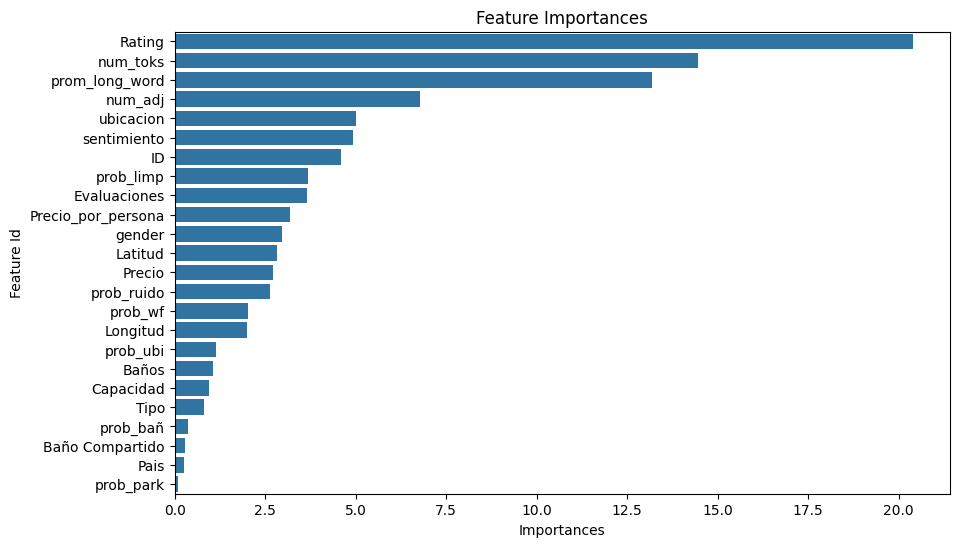

In [18]:
feature_importances = catb_reg.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['Importances'], y=feature_importances['Feature Id'])
plt.title('Feature Importances')
plt.show()

### **Gráfico de residuos**

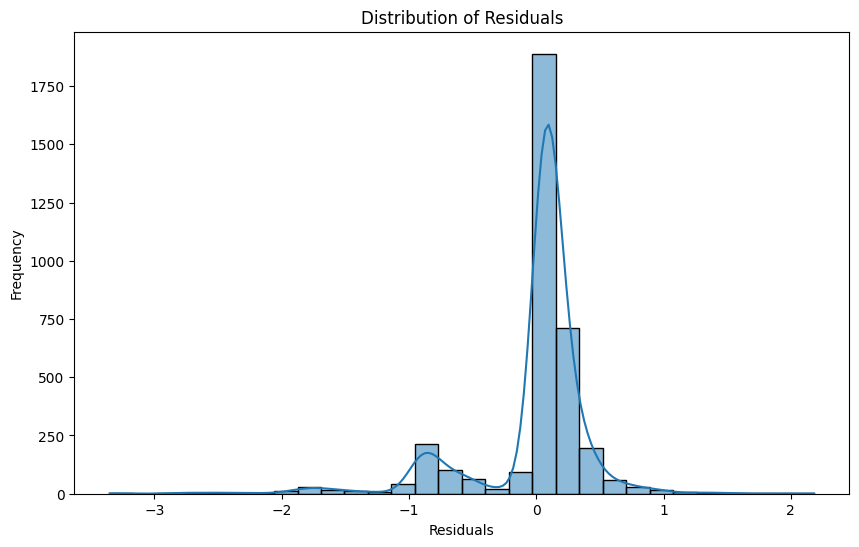

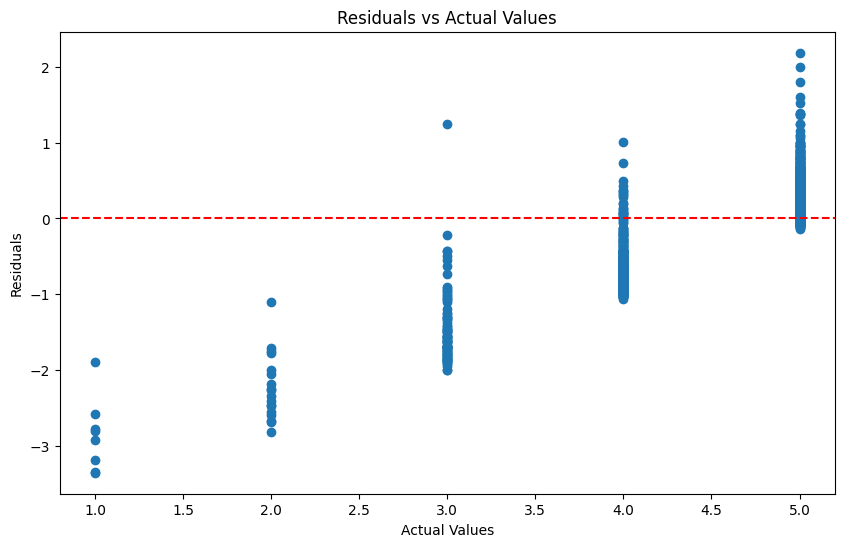

In [19]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

### **Shap values**

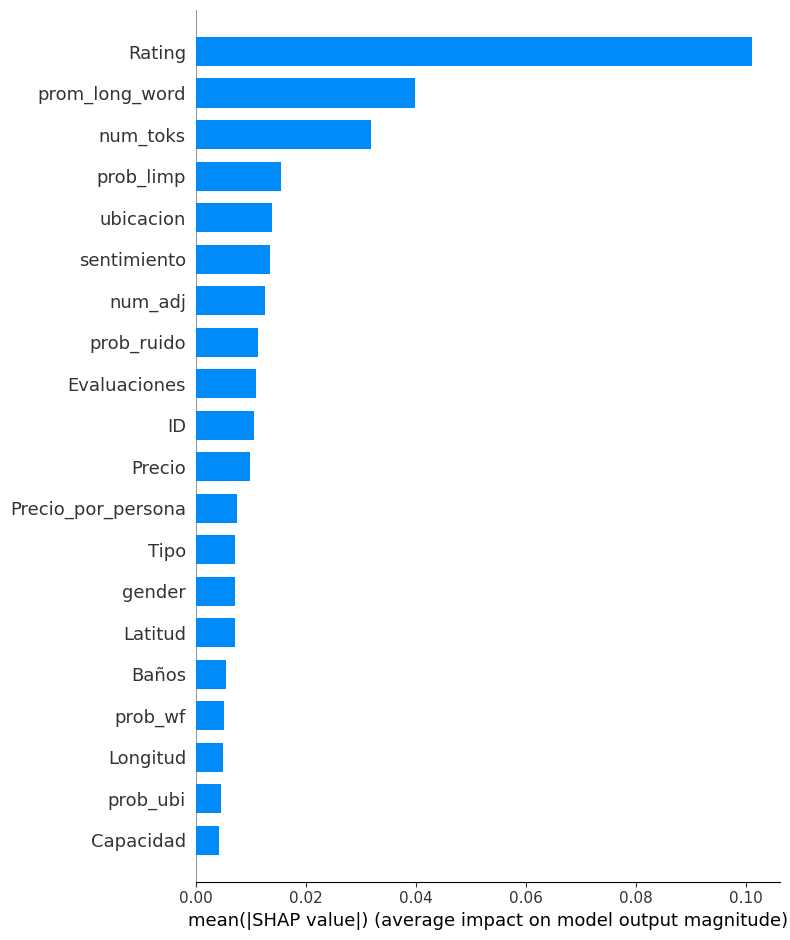

In [21]:
explainer = shap.TreeExplainer(catb_reg)
shap_values = explainer.shap_values(X_test)

# Visualización de los SHAP values

# 1. Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


# 3. Force Plot (para una observación específica)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])